## <p style="text-align: center;">B9AI103_2122_TMD3_CA_1</p>
### <p style="text-align: center;"> Details </p>
#### <p style="text-align: center;">Name: Sunil Judhistira Gauda</p>
#### <p style="text-align: center;">Student ID : 10595858 </p>

## Hybrid Movie Recommendation using Movie Lense Large Data set

Note : 
* Running cosine similarity might take some computaion and time

### Imports
1. numpy, pandas - for numeric computation and data management
2. scikit learn - for TFIDF Vectorising and cosine similarity
3. surprise - scikit learn extension to work on rating based data
    * surprise may or may not install directly depending on OS, below is the direct way of downloading and installing scikit-surprise
    * Installation Instructions
        * pip install numpy cython
        * git clone https://github.com/NicolasHug/surprise.git
        * cd surprise
        * python setup.py install
4. wordcloud - represent word density
5. itertools - create a combination to work with

In [97]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader, Dataset, SVD
from surprise.model_selection import KFold
from surprise.model_selection.validation import cross_validate
import matplotlib.pyplot as plt
from  wordcloud import WordCloud
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity


### Importing the data
* Data we require are as follows
    * Meta-Data like **Genre** for **content based** filtering
    * User Data like **Ratings** for **collaberative** filtering
* **Hybrid** recommendation will be the combination of **content and collaberative** filtering

In [98]:
use_large = False
if use_large:
    movies = pd.read_csv("../../../../DataSets/ml-latest/movies.csv")
    ratings = pd.read_csv("../../../../DataSets/ml-latest/ratings.csv")
    tags = pd.read_csv("../../../../DataSets/ml-latest/tags.csv")
    links = pd.read_csv("../../../../DataSets/ml-latest/links.csv")
    g_tags = pd.read_csv("../../../../DataSets/ml-latest/genome-tags.csv")
    g_scores = pd.read_csv("../../../../DataSets/ml-latest/genome-scores.csv")
else :
    movies = pd.read_csv("../../../../DataSets/ml-latest-small/movies.csv")
    ratings = pd.read_csv("../../../../DataSets/ml-latest-small/ratings.csv")
    tags = pd.read_csv("../../../../DataSets/ml-latest-small/tags.csv")
    links = pd.read_csv("../../../../DataSets/ml-latest-small/links.csv")

### Exploratory Analysis of the Data
Steps inncluded for Data Analysis includes
* Data Preparation
* Data Exploration
* Data Visualisation

#### Data Preparation

##### Seperating **Year** from the **Titile** of the movie
* As the data we have merged the title of the movie with the date it was released we dont have any seperate data for year of release
* Using few techniques below we will seperate date from the title and convert date into int and title into string

In [99]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*',expand = False)
movies['year'] = movies['year'].str.extract('(\d+)', expand=False)
movies.dropna(inplace=True)
movies['year'] = movies['year'].astype(int)
movies['title'] = movies['title'].replace(r'\([^)]*\)', '', regex=True).str.lower()
movies['title'] = movies['title'].str.rstrip()
movies['title'] = movies['title'].str.lstrip()
movies['title'] = movies['title'].astype("string")
movies.head()

,movieId,title,genres,year
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,jumanji,Adventure|Children|Fantasy,1995
2,3,grumpier old men,Comedy|Romance,1995
3,4,waiting to exhale,Comedy|Drama|Romance,1995
4,5,father of the bride part ii,Comedy,1995


##### Preparing the final DataFrame
Final Data Frame contains all the data required for exploratory analysis of the data and visualise the data using various techniques.

In [100]:
# Preparing the Data frame by combining all necessary columns from other dataframes
final_df = movies
final_df["userid"] = ratings["userId"]
final_df["rating"] = ratings["rating"]
final_df["timestamp"] = ratings["timestamp"]
final_df["tag"] = tags["tag"]
final_df["tmdbId"] = links["tmdbId"]


##### Dropping the NA columns
As we have a huge amount of data, and the NA counts for tags only, that is also few hundread of the entire dataset we can get rid of NA rows.

In [101]:
final_df.dropna(inplace=True)
final_df.isna().sum()

movieId      0
title        0
genres       0
year         0
userid       0
rating       0
timestamp    0
tag          0
tmdbId       0
dtype: int64

#### Data Exploration

**Sample of our final data set**

In [102]:
final_df.head()

,movieId,title,genres,year,userid,rating,timestamp,tag,tmdbId
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,4.0,964982703,funny,862.0
1,2,jumanji,Adventure|Children|Fantasy,1995,1,4.0,964981247,Highly quotable,8844.0
2,3,grumpier old men,Comedy|Romance,1995,1,4.0,964982224,will ferrell,15602.0
3,4,waiting to exhale,Comedy|Drama|Romance,1995,1,5.0,964983815,Boxing story,31357.0
4,5,father of the bride part ii,Comedy,1995,1,5.0,964982931,MMA,11862.0


**Shape of the Data**

In [103]:
final_df.shape

(3679, 9)

**Data Description**

In [104]:
final_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3679 entries, 0 to 3682
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movieId    3679 non-null   int64  
 1   title      3679 non-null   string 
 2   genres     3679 non-null   object 
 3   year       3679 non-null   int32  
 4   userid     3679 non-null   int64  
 5   rating     3679 non-null   float64
 6   timestamp  3679 non-null   int64  
 7   tag        3679 non-null   object 
 8   tmdbId     3679 non-null   float64
dtypes: float64(2), int32(1), int64(3), object(2), string(1)
memory usage: 273.1+ KB


##### Listing the top 10 rated movies

In [105]:
final_df[['title', 'rating']].sort_values('rating', ascending=False).head(10)

,title,rating
1841,virus,5.0
421,lassie,5.0
3070,ishtar,5.0
3066,hiding out,5.0
3064,gardens of stone,5.0
1466,child's play,5.0
419,kalifornia,5.0
3057,cop,5.0
1467,child's play 2,5.0
407,"house of the spirits, the",5.0


#### Data Visualization

##### Movies released per year
By plotting movies angainst the year of release we can clearly see that by the year 1980 - 2000 the release was at peak, i.e maximum movies were released that year as per our data set.

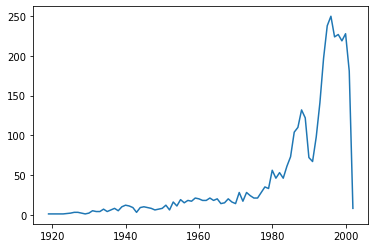

Max No.of Movies Relesed = 250
year = 1996


count     82.000000
mean      44.865854
std       66.135245
min        1.000000
25%        7.250000
50%       17.000000
75%       46.000000
max      250.000000
Name: title, dtype: float64

In [106]:
plt.plot(final_df.groupby('year').title.count())
plt.show()
a = final_df.groupby('year').title.count()
print('Max No.of Movies Relesed =', a.max())
for i in a.index:
    if a[i] == a.max():
        print('year =', i)
a.describe()


##### Exploring Genre's

In [107]:
genre_popularity = (final_df.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)


Drama        1720
Comedy       1374
Thriller      687
Romance       669
Action        597
Adventure     445
Crime         411
Horror        350
Sci-Fi        322
Children      275
Name: genres, dtype: int64

(-0.5, 999.5, 399.5, -0.5)

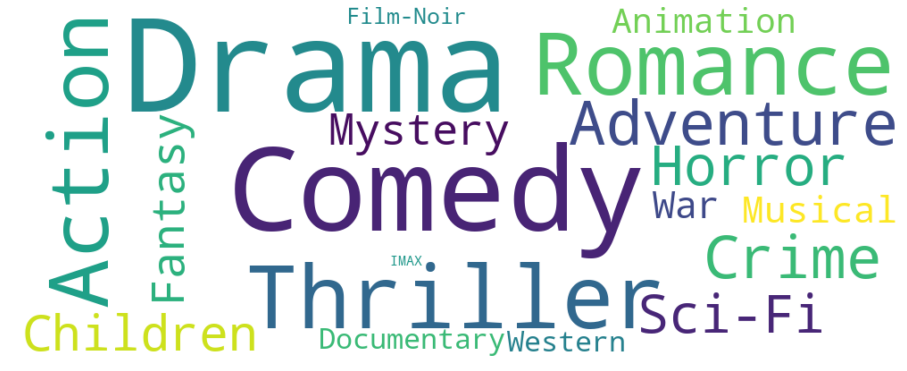

In [108]:
genre_wc = WordCloud(width=1000,height=400,background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())
plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

#### Content Based Filtering
There are two types of filtering in content based movie recommendation
1. Description Based - Based on textual description of the movie or the taglines/punchlines
2. Meta data based - Genre, Keywords etc <br />
As we only have metadata of the movies, we will work with Meta Data based filtering

In [109]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                     for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape


(3679, 538)

In [110]:
cosine_sim = cosine_similarity(tfidf_matrix)

In [111]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [112]:
indices = pd.Series(final_df.index, index=final_df['title']).drop_duplicates()

In [113]:
def recommend(title, cosine_sim=cosine_sim) :
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x:x[1], reverse = True)
    # Top 15
    sim_scores = sim_scores[1:16]
    movie_indices = [i[0] for i in sim_scores]
    for i in movie_indices:
        pop = final_df.at[i, 'rating']
        if pop<5 or pop>10:
            movie_indices.remove(i)

    return final_df[["title", "rating"]].iloc[movie_indices]

In [114]:
final_df.head()
indices


title
toy story                         0
jumanji                           1
grumpier old men                  2
waiting to exhale                 3
father of the bride part ii       4
                               ... 
walk to remember, a            3678
beijing bicycle                3679
escaflowne: the movie          3680
maelström                      3681
metropolis                     3682
Length: 3679, dtype: int64

In [115]:

recommend('toy story')


,title,rating
2355,toy story 2,2.0
3000,"emperor's new groove, the",2.5
1505,"black cauldron, the",3.0
2539,we're back! a dinosaur's story,3.0
3336,"land before time, the",4.5
1757,"bug's life, a",4.5
3194,shrek,4.5


In [116]:
reader = Reader()
u_df = Dataset.load_from_df(ratings[['userId', 'rating', 'movieId']], reader)
kf = KFold(n_splits=5)
kf.split(u_df)

<generator object KFold.split at 0x000002E30D6427A0>

In [117]:
svd = SVD()
cross_validate(svd, u_df, measures=['RMSE', 'MAE'])
trainset = u_df.build_full_trainset()
svd.fit(trainset)


In [118]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [119]:
col = np.array(links['tmdbId'], np.int64)
links['tmdbId'] = col

# Merge movies_metadata.csv and links_small.csv files
links = links.merge(
    final_df[['title', 'tmdbId']], on='tmdbId').set_index('title')
links_index = links.set_index('tmdbId')


In [120]:
# Recommendation function
def hybrid(userId, title):
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]  # Scores of the 30 most similar movies
    movie_indices = [i[0] for i in sim_scores]

    movies = final_df.iloc[movie_indices][['title','rating','tmdbId']]
    movies['est'] = movies['tmdbId'].apply(lambda x: svd.predict(
        userId, links_index.loc[x]['movieId']).est)  # Estimated prediction using svd
    # Rank movies according to the predicted values
    movies = movies.sort_values('est', ascending=False)
    movies.columns = ['Title' , 'Rating',
                      'TMDb Id', 'Estimated Prediction']
    return movies.head(15)  # Display top 15 similar movies


In [121]:
hybrid(1, 'toy story')


,Title,Rating,TMDb Id,Estimated Prediction
1706,antz,4.5,8916.0,5
2355,toy story 2,2.0,863.0,5
1756,"rugrats movie, the",4.0,14444.0,5
599,wallace & gromit: a close shave,3.0,532.0,5
2250,who framed roger rabbit?,4.0,856.0,5
1372,quest for camelot,4.0,18937.0,5
789,alice in wonderland,3.0,12092.0,5
551,james and the giant peach,4.0,10539.0,5
585,wallace & gromit: the best of aardman animation,4.0,503475.0,5
2106,little nemo: adventures in slumberland,4.5,22611.0,5
